# Face Generation

In this project, Deep Convolutional Generative Adversarial Network(DCGAN) will be developed on a dataset of faces. The objective is to build a generator network to generate *new* images of faces that look as realistic as possible!


### 1. Get the Data

The source of the data are from [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks.


### 2. Pre-processed Data

Some pre-processing has been performed on the images such as each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Sample data as shown below.

<img src='assets/processed_face_data.png' width=60% />

Data Source: (https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)



### 3. Import Dependencies Library

In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.nn import init

##### Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### 4. Load the Data

* Images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Write a DataLoader that shuffles and batches these Tensor images.

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform_fn = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=transform_fn)
    data_loader = torch.utils.data.DataLoader(data, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    return data_loader

# Define function hyperparameters - batch size & image_size
## Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!
batch_size = 24
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

### 5. Visualization of sample images

Below are square images of somewhat-centered faces. Tensor images need to be converted into a NumPy type and transpose the dimensions to correctly display an image.

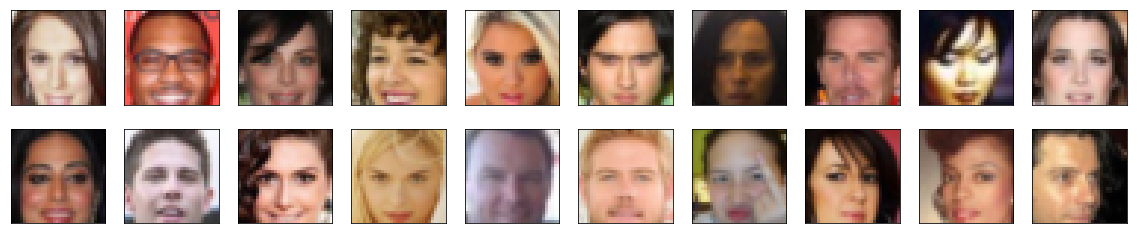

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### 6. Perform images transformation
##### Scaling images to a pixel range of -1 to 1

As the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9294)
Max:  tensor(0.8902)


### 7. Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

##### Discriminator

First task is to define the discriminator. This is a convolutional classifier without any maxpooling layers and a deep network with **normalization** will be used.

* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
# Build a helper function to call conv layer
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # init function
        self.conv_dim = conv_dim
        
        # Add Convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) #(64,64,64)
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 64)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 128)
        
        # final fully connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        # Add a dropout layer can lead to a more stable performance
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        x = self.dropout(x)
        
        return x

##### Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                             kernel_size, stride, padding, bias=False)
    
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        # add the dropout layer
        x = self.dropout(x)
        # layer reshape
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer using tanh activation function
        x = F.tanh(self.t_conv3(x))
        
        return x

### 8. Initialize the weights of neural networks

From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), it is said that:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

References are made from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py).

* Weight initialization for **convolutional** and **linear** layers.
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, will be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """

    init_gain = 0.02
    
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
            
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

### 9. Define model hyperparameters


In [16]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4)

##### Training on GPU

Check if can train on GPU. 

>* Models,
* Model inputs, and
* Loss function arguments

The above will be moved to GPU, where appropriate.

In [17]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
### 10. Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

##### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* The discriminator are to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


##### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.


In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # to smooth real labels = 0.9
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels =1
    # move labels to GPU if available    
    if train_on_gpu:
        labels = labels.cuda()
    #binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels=0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### 11. Set up Optimizers


In [19]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
### 12. Model Training

Training will involve alternating between training the discriminator and the generator. Functions `real_loss` and `fake_loss` created will help to calculate the discriminator losses.

* The training will be done on the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ====================================
            #         TRAIN THE NETWORKS
            # ====================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            # Train with real images
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Train with fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and proceed to backpropagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images
            # using flipped labels
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [21]:
# set number of epochs 
n_epochs = 15

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   15] | d_loss: 2.0720 | g_loss: 2.9941
Epoch [    1/   15] | d_loss: 0.7099 | g_loss: 9.7746
Epoch [    1/   15] | d_loss: 0.9365 | g_loss: 0.6986
Epoch [    1/   15] | d_loss: 1.4460 | g_loss: 7.5579
Epoch [    1/   15] | d_loss: 0.9585 | g_loss: 7.8893
Epoch [    1/   15] | d_loss: 0.7603 | g_loss: 5.4201
Epoch [    1/   15] | d_loss: 1.6571 | g_loss: 3.2610
Epoch [    1/   15] | d_loss: 0.9544 | g_loss: 6.7259
Epoch [    1/   15] | d_loss: 1.4555 | g_loss: 9.9807
Epoch [    1/   15] | d_loss: 0.9114 | g_loss: 4.7104
Epoch [    1/   15] | d_loss: 0.7738 | g_loss: 1.8071
Epoch [    1/   15] | d_loss: 0.6989 | g_loss: 5.0815
Epoch [    1/   15] | d_loss: 1.0599 | g_loss: 3.3979
Epoch [    1/   15] | d_loss: 1.4588 | g_loss: 4.3253
Epoch [    1/   15] | d_loss: 0.7567 | g_loss: 2.9687
Epoch [    1/   15] | d_loss: 0.7964 | g_loss: 2.9904
Epoch [    1/   15] | d_loss: 1.0469 | g_loss: 3.5977
Epoch [    1/   15] | d_loss: 0.9459 | g_loss: 3.9181
Epoch [    1/   15] | d_loss

### 13. Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

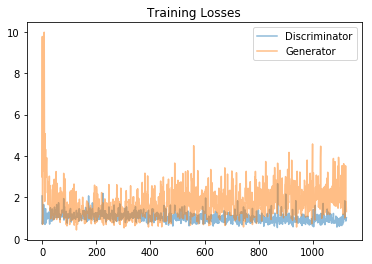

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### 14. Generator samples from training

View samples of images from the generator.

In [23]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

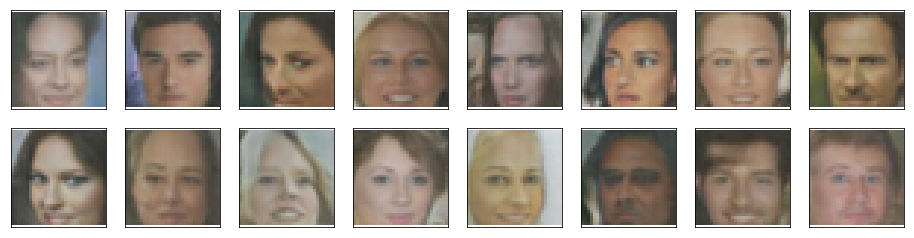

In [25]:
_ = view_samples(-1, samples)

##### Model takeaway:

* The models were deep enough to recognize facial features and give good predictions.

- Higher conv_dim seem to bring better result.
- Adam optimizer is good to use when there are inputs of noises since it can be adaptive.
- Consider to further reduce the number of epochs as higher epoch seem to reduce the oscillation.

- Next commit: To try out larger model size for it to learn more features in a data feature space.